In [1]:
# Packages for Data Wrangling
import numpy as np
import pandas as pd
import os
import re
from collections import Counter

# For graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Use cleaner absolute path to find file
path = os.path.abspath('politifact.csv')
df = pd.read_csv(path, index_col=0)

In [3]:
# Check for null values and total number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16611 entries, 0 to 16610
Data columns (total 4 columns):
statement    16611 non-null object
source       16611 non-null object
link         16611 non-null object
veracity     16611 non-null object
dtypes: object(4)
memory usage: 648.9+ KB


# Initially 16611 rows of non-null data

In [4]:
# to see statement in full
pd.set_option('display.max_colwidth', 200) 

# See sample of data
df.head(3)

,statement,source,link,veracity
0,"Says that in 1770 ""British parliament banned lipstick, saying it had the power to seduce men into marriage, which was classified as witchcraft.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/25/facebook-posts/no-british-parliament-didnt-ban-witchcraft-lipstic/,Pants on Fire!
1,"Says Ann Landers said, ""At age 20, we worry about what others think of us. At age 40, we don’t care what they think. At age 60, we discover that they have not been thinking of us at all.""",Viral image,/facebook-fact-checks/statements/2019/oct/25/viral-image/no-evidence-ann-landers-said-quote-about-age/,False
2,"""General Motors is making record profits.""",Glenn Kage,/missouri/statements/2019/oct/25/glenn-kage/general-motors-profits-have-been-record-setting-no/,Half-True


In [5]:
# check groups that exist in veracity column
df.veracity.value_counts()

False             3274
Half-True         3158
Mostly True       3010
Mostly False      2756
True              2340
Pants on Fire!    1817
Full Flop          159
Half Flip           70
No Flip             27
Name: veracity, dtype: int64

In [6]:
# Full Flop, Half Flip, & No Flip have nothing to do with veracity; remove them
# Half-True, Mostly True, & Mostly False are non-exclusive groups; remove them
ver_df = df[df.isin(['True',
                    'False',
                    'Pants on Fire!']).any(axis=1)]

In [7]:
# The total number of rows should sum to 7431 (false(3274) + true(2340) + pants on fire(1817) = 7431)
ver_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7431 entries, 0 to 16610
Data columns (total 4 columns):
statement    7431 non-null object
source       7431 non-null object
link         7431 non-null object
veracity     7431 non-null object
dtypes: object(4)
memory usage: 290.3+ KB


# 7431 rows survived

In [8]:
# check if large imbalance in the 3 classes
ver_df.veracity.value_counts()

False             3274
True              2340
Pants on Fire!    1817
Name: veracity, dtype: int64

In [9]:
# randomly sample 10 rows
ver_df.iloc[0:100:10]

,statement,source,link,veracity
0,"Says that in 1770 ""British parliament banned lipstick, saying it had the power to seduce men into marriage, which was classified as witchcraft.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/25/facebook-posts/no-british-parliament-didnt-ban-witchcraft-lipstic/,Pants on Fire!
14,"Barnes & Noble and Target have the book ""If You Give a Pig the White House"" in their children’s sections.",Viral image,/facebook-fact-checks/statements/2019/oct/24/viral-image/barnes-noble-isnt-selling-if-you-give-pig-white-ho/,False
28,"Says California has ""30% or a third of the country’s people living at or below the poverty level.""",Mark Batinick,/illinois/statements/2019/oct/20/mark-batinick/no-30-nations-poor-dont-reside-california/,False
49,"Says Fox News anchor Shepard Smith stepped down after Attorney General William Barr ""had a closed door meeting with Rupert Murdoch.""",The Other 98%,/punditfact/statements/2019/oct/14/other-98/theres-no-proof-barr-played-role-shepard-smiths-fo/,False
62,"Says the sons of Nancy Pelosi, Mitt Romney and John Kerry are all on the boards of ""energy companies doing business in Ukraine.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/10/facebook-posts/pelosi-romney-and-kerry-dont-have-sons-working-com/,False
74,"Says Rep. Adam Schiff was ""complicit in EDITING AND COMPOSING THE ‘WHISTLEBLOWER COMPLAINT’ BEFORE IT WAS FILED.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/04/facebook-posts/theres-no-evidence-schiff-helped-write-whistleblow/,False
90,"Siobhan Dunnavant ""wrote the Republican bill that would let insurance companies deny coverage for pre-existing conditions.""",Rodman Debra,/virginia/statements/2019/oct/01/rodman-debra/rodman-misstates-dunnavants-short-term-health-insu/,False
105,"Says Gov. Tony Evers vetoed a school computer program, ""saying it would be better spent in urban districts like Madison and Milwaukee.""",Rob Swearingen,/wisconsin/statements/2019/sep/27/rob-swearingen/state-rep-exaggerates-claim-gov-tony-evers-veto-sc/,False
119,Says a photo shows that climate change protesters left trash all over their protest side.,Facebook posts,/facebook-fact-checks/statements/2019/sep/24/facebook-posts/photo-doesnt-show-trash-left-climate-strike-protes/,False
141,"""U.S. agricultural & food exports are expected to increase more than $2 billion annually under #USMCA""",Roy Blunt,/missouri/statements/2019/sep/17/roy-blunt/report-backs-blunt-claim-2-billion-increase-trade-/,True


# Should remove statements that begin with "Says entity said" as there are 2 reasons this may be false: speaker is false or statement is false.

# Filter for sentences that begin with a quotation

In [10]:
ver_df[ver_df.statement.str.match(r"\"")==True][0:100:10]

,statement,source,link,veracity
3,"""14,000 abandoned wind turbines litter the United States.""",Chain email,/missouri/statements/2019/oct/25/chain-email/no-there-arent-14000-abandoned-wind-turbines-litte/,Pants on Fire!
53,"""West Virginia Department of Education reported over 10,000 children and youth have been identified as homeless for the 2018-2019 school year.""",Joe Manchin,/west-virginia/statements/2019/oct/11/joe-manchin/how-many-west-virginia-students-are-homeless/,True
101,"""In Congress, Elizabeth Warren introduced 110 bills. 2 passed. Cory Booker introduced 120 bills. 0 passed. Kamala Harris introduced 54 bills. 0 passed. Bernie Sanders never held a job until age 53...",Facebook posts,/facebook-fact-checks/statements/2019/sep/27/facebook-posts/social-media-posts-mislead-democratic-senators-rec/,False
180,"""America has more governors who’ve worn blackface than black governors.""",Samuel Sinyangwe,/punditfact/statements/2019/sep/06/samuel-sinyangwe/its-true-there-are-more-governors-who-have-worn-bl/,True
233,"""Yesterday we had the strongest dollar in the history of our country.""",Donald Trump,/truth-o-meter/statements/2019/aug/22/donald-trump/donald-trump-incorrect-us-dollar-strongest-its-eve/,False
302,"""Elijah Cummings’ house was broken into after Trump publicly attacked him on Twitter.""",Chelsea Handler,/punditfact/statements/2019/aug/02/chelsea-handler/chelsea-handler-blames-trumps-tweets-break-cumming/,False
364,"""San Francisco has spent $72.5 million this fiscal year cleaning up human waste and drug paraphernalia"" and ""there are more drug users on their public needle program than high school graduates.""",Turning Point USA,/facebook-fact-checks/statements/2019/jul/16/turning-point-usa/san-francisco-isnt-spending-725-million-clean-huma/,False
400,"""The wealthiest three families now own more wealth than the bottom half of the country.""",Bernie Sanders,/truth-o-meter/statements/2019/jul/03/bernie-sanders/bernie-sanders-target-saying-3-richest-have-much-w/,True
456,"""Barack Obama said, ‘If we don’t do something about this president, I will’ at DNC fundraiser last night.""",Viral image,/facebook-fact-checks/statements/2019/jun/19/viral-image/no-evidence-obama-said-if-we-dont-do-something-abo/,False
507,"""We saw the prison population expand and vacancy rates for correctional officers go from 2.9% to 15.2%"" over the last eight years.",Chris Taylor,/wisconsin/statements/2019/jun/04/chris-taylor/wisconsin-state-rep-chris-taylor-mark-prison-claim/,True


# Precision: 100% 
## true positive / (true positive + false positive)

In [11]:
ver_df[ver_df.statement.str.match(r"\"")==False][0:100:10]

,statement,source,link,veracity
0,"Says that in 1770 ""British parliament banned lipstick, saying it had the power to seduce men into marriage, which was classified as witchcraft.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/25/facebook-posts/no-british-parliament-didnt-ban-witchcraft-lipstic/,Pants on Fire!
22,"AARP backed ""federal funding for Planned Parenthood.""",Association of Mature American Citizens,/truth-o-meter/statements/2019/oct/22/association-mature-american-citizens/online-ads-claiming-aarp-backed-federal-funding-pl/,False
49,"Says Fox News anchor Shepard Smith stepped down after Attorney General William Barr ""had a closed door meeting with Rupert Murdoch.""",The Other 98%,/punditfact/statements/2019/oct/14/other-98/theres-no-proof-barr-played-role-shepard-smiths-fo/,False
68,"Del. Danica Roem ""supported a controversial bill that would have allowed abortion up until the moment of birth.",Kelly McGinn,/virginia/statements/2019/oct/09/kelly-mcginn/kelly-mcginn-invents-position-danica-roem-abortion/,False
87,"Says a photo shows Beto O’Rourke ""in college drunk and pissing his pants.""",Viral image,/facebook-fact-checks/statements/2019/oct/02/viral-image/photo-philadelphia-musician-not-beto-orourke/,Pants on Fire!
106,A photograph shows a woman doing cocaine with a child.,Viral image,/facebook-fact-checks/statements/2019/sep/26/viral-image/no-woman-isnt-snorting-cocaine-child/,Pants on Fire!
123,"Quotes Winston Churchill as saying ""Diplomacy is the art of telling people to go to hell in such a way that they ask for directions.""",Bloggers,/facebook-fact-checks/statements/2019/sep/20/blog-posting/no-evidence-churchill-said-quote-about-diplomacy-b/,False
149,"Says John Bolton ""fundamentally was a man of the left.""",Tucker Carlson,/punditfact/statements/2019/sep/13/tucker-carlson/tucker-carlson-falsely-claims-john-bolton-was-man-/,Pants on Fire!
171,Says a Donald Trump tweet credited Gov. Ron DeSantis for Hurricane Dorian’s path away from Florida.,Facebook posts,/facebook-fact-checks/statements/2019/sep/06/facebook-posts/donald-trump-did-not-credit-florida-gov-ron-desant/,Pants on Fire!
191,"Says Winston Churchill said, ""You have enemies? Good. That means you’ve stood up for something, sometime in your life.""",Facebook posts,/facebook-fact-checks/statements/2019/sep/04/facebook-posts/quote-attributed-churchill-having-enemies-original/,False


# Negative Predictive Value: 100% 
## true negative / (true negative + false negative)

In [12]:
# Let's see how much data remains with this filtering method, i.e., how many are True
Counter(ver_df.statement.str.match(r"\""))

Counter({False: 4016, True: 3415})

In [13]:
# verify above results using a different method
Counter(ver_df.statement.str.startswith('"'))

Counter({False: 4016, True: 3415})

# 3415 rows survive

# Do other filters give better survival rates?

# Filter: contains second-hand statement

In [14]:
ver_df[ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said")==True][0:100:10]

,statement,source,link,veracity
0,"Says that in 1770 ""British parliament banned lipstick, saying it had the power to seduce men into marriage, which was classified as witchcraft.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/25/facebook-posts/no-british-parliament-didnt-ban-witchcraft-lipstic/,Pants on Fire!
26,"Says a photo shows ""Kurdish kids"" after Turkey’s invasion.",Viral image,/facebook-fact-checks/statements/2019/oct/21/viral-image/these-photos-are-palestinian-and-syrian-children-n/,False
54,"Says Facebook now has a ""witch checker.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/11/facebook-posts/viral-posts-about-facebook-witch-checker-just-bunc/,Pants on Fire!
79,"Quotes Thomas Jefferson as saying that ""freedom is lost gradually from uninterested, uninformed and uninvolved people.""",Facebook posts,/facebook-fact-checks/statements/2019/oct/04/facebook-posts/jefferson-didnt-say-freedom-lost-gradually-uninter/,False
107,Says Andy Rooney wrote a long commentary defending prayer and Christianity in the United States.,Viral image,/facebook-fact-checks/statements/2019/sep/26/viral-image/texas-sports-editor-wrote-column-christianity-and-/,False
132,"Says Ilhan Omar ""partied"" on the anniversary of 9/11.",Donald Trump,/truth-o-meter/statements/2019/sep/19/donald-trump/trump-retweets-false-claim-ilhan-omar-partied-911-/,Pants on Fire!
167,"Says after a car accident comedian Kevin Hart has been ""paralyzed from the neck down"" and his ""vocal cords have been paralyzed as well, leaving him with the inability to speak.""",Facebook posts,/facebook-fact-checks/statements/2019/sep/09/facebook-posts/no-kevin-hart-wasnt-paralyzed-neck-down-didnt-inju/,False
193,"Says the ""bones of children"" were found on Jeffrey Epstein’s island.",Facebook posts,/facebook-fact-checks/statements/2019/sep/04/facebook-posts/no-bones-children-were-not-discovered-jeffrey-epst/,False
222,"Says 194 people were killed in mass shootings in 2018 while undocumented immigrants killed 83,211 people.",Facebook posts,/facebook-fact-checks/statements/2019/aug/26/facebook-posts/post-comparing-mass-shooting-deaths-homicides-undo/,False
248,"Says CNN President Jeff Zucker ordered employees to downplay Bill Clinton’s relationship with Jeffrey Epstein and make it look like Epstein was ""Trump’s partner in all of this.""",Facebook posts,/facebook-fact-checks/statements/2019/aug/16/facebook-posts/no-cnn-president-jeff-zucker-didnt-order-employees/,Pants on Fire!


# Precision: 100%

In [15]:
ver_df[ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said")==False][0:100:10]

,statement,source,link,veracity
3,"""14,000 abandoned wind turbines litter the United States.""",Chain email,/missouri/statements/2019/oct/25/chain-email/no-there-arent-14000-abandoned-wind-turbines-litte/,Pants on Fire!
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False
72,"Del. Debra Rodman ""opposes adoption as an alternative to abortion in event of unplanned pregnancies.""",Siobhan Dunnavant,/virginia/statements/2019/oct/08/siobhan-dunnavant/dunnavant-falsely-claims-rodman-favors-abortion-ov/,False
104,"The Green New Deal ""would put a $600,000 tax burden on every household.""",Republican Party of Florida,/florida/statements/2019/sep/27/republican-party-florida/gop-talking-point-green-new-deal-will-cost-every-h/,False
148,"The Odessa shooter ""had a Beto sticker on his truck.""",Viral image,/facebook-fact-checks/statements/2019/sep/13/viral-image/no-evidence-odessa-shooter-had-sticker-his-vehicle/,False
182,"The Amazon rainforest fires are ""directly related to trade"" tensions between the United States and China.",John Delaney,/truth-o-meter/statements/2019/sep/06/john-delaney/trumps-trade-war-blame-amazon-wildfires-s-reach/,False
214,"""89,000 children were separated from their parents under Obama"" and ""only 1,900 children have been separated under Trump.""",Facebook posts,/facebook-fact-checks/statements/2019/aug/27/facebook-posts/facebook-post-makes-inaccurate-comparison-family-s/,False
240,"""Wow, Report Just Out! Google manipulated from 2.6 million to 16 million votes for Hillary Clinton in 2016 Election!""",Donald Trump,/truth-o-meter/statements/2019/aug/19/donald-trump/donald-trump-wrong-google-manipulating-election-re/,False
291,"There are ""more gun deaths by far"" in the United States than any other country in the world.",Dianne Feinstein,/california/statements/2019/aug/06/dianne-feinstein/fact-check-are-there-more-gun-deaths-far-america-a/,False
332,"""George Washington, as many don’t know, was not the first President of the United States. The first President of the United States was one John Hanson, and he was a black man.""",Bloggers,/facebook-fact-checks/statements/2019/jul/25/blog-posting/no-first-american-president-wasnt-black-man-named-/,False


# Negative Predictive Value: 100%

In [16]:
Counter(ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said"))

Counter({True: 2165, False: 5266})

# 5266 rows survive

# While more rows survive, the quality of the suriving rows is questionable. For example, 

## Del. Debra Rodman "opposes adoption as an alternative to abortion in event of unplanned pregnancies."

# Liars may use distancing language such as "she" and since the above quote was edited to indicate the subject, Del. Debra Rodman, the quality of this falsehood diminishes. This can also be said of 104, 148, etc.

# We'll use a begins-with-and-ends-with-quotations filter going forward

In [17]:
quote_df = ver_df[ver_df.statement.str.match(r'\"')==True]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3415 entries, 3 to 16610
Data columns (total 4 columns):
statement    3415 non-null object
source       3415 non-null object
link         3415 non-null object
veracity     3415 non-null object
dtypes: object(4)
memory usage: 133.4+ KB


In [18]:
# remove sentences that don't end with a quotation
quote_df = quote_df[quote_df.statement.str.endswith('"')==True]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 3 to 16610
Data columns (total 4 columns):
statement    3171 non-null object
source       3171 non-null object
link         3171 non-null object
veracity     3171 non-null object
dtypes: object(4)
memory usage: 123.9+ KB


In [19]:
# remove sentences that are several quotes strung together
quote_df = quote_df[quote_df.statement.str.contains(r'\"{1}.+\"{1}.+\"{1}')==False]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3083 entries, 3 to 16610
Data columns (total 4 columns):
statement    3083 non-null object
source       3083 non-null object
link         3083 non-null object
veracity     3083 non-null object
dtypes: object(4)
memory usage: 120.4+ KB


In [20]:
quote_df.veracity.value_counts()

False             1246
True              1137
Pants on Fire!     700
Name: veracity, dtype: int64

In [21]:
# how many unique sources?
quote_df.describe(include='all')

,statement,source,link,veracity
count,3083,3083,3083,3083
unique,3082,1281,3083,3
top,"""Obama says Iran is a 'tiny' country, 'doesn't pose a serious threat.'""",Bloggers,/truth-o-meter/statements/2009/apr/30/john-boehner/boehner-cites-debt-day-numbers-carefully/,False
freq,2,201,1,1246


In [22]:
# top 10 sources
quote_df.source.value_counts()[:10]

Bloggers           201
Donald Trump       181
Barack Obama       101
Hillary Clinton     58
John McCain         49
Mitt Romney         42
Chain email         41
Viral image         36
Facebook posts      35
Rick Perry          28
Name: source, dtype: int64

# There is an imbalance in the sources (some appear far too often)

# By examining the source frequency's mean and median, we can determine how many times most sources are quoted to figure out a way to balance the data

In [23]:
quote_df.source.value_counts().mean()

2.4067135050741606

In [24]:
quote_df.source.value_counts().median()

1.0

In [25]:
sum(quote_df.source.value_counts() <= 3)

1165

In [26]:
quote_df['freq'] = quote_df.groupby('source')['source'].transform('count')

In [27]:
quote_df[quote_df.freq <= 3].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 18 to 16610
Data columns (total 5 columns):
statement    1455 non-null object
source       1455 non-null object
link         1455 non-null object
veracity     1455 non-null object
freq         1455 non-null int64
dtypes: int64(1), object(4)
memory usage: 68.2+ KB


# New dataframe will only tolerate a single source appearing 3 times

In [28]:
balanced_df = quote_df[quote_df.freq <= 3]

In [29]:
# how many unique sources?
balanced_df.describe(include='all')

,statement,source,link,veracity,freq
count,1455,1455,1455,1455,1455.000000
unique,1455,1165,1455,3,NaN
top,"""If the impeachment reaches the house and passes to the senate and isn’t passed the first term is nullified and Trump can run two more terms.""",Mitch McConnell,/rhode-island/statements/2013/jan/13/dawson-hodgson/rhode-island-sen-dawson-hodgson-says-state-spends-/,False,NaN
freq,1,3,1,576,NaN
mean,NaN,NaN,NaN,NaN,1.471478
std,NaN,NaN,NaN,NaN,0.684153
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,2.000000


In [30]:
balanced_df.veracity.value_counts()

False             576
True              571
Pants on Fire!    308
Name: veracity, dtype: int64

In [31]:
# top 10 sources
balanced_df.source.value_counts()[:10]

Mitch McConnell       3
Jeff Kottkamp         3
Kirsten Gillibrand    3
Ron Wyden             3
Michael Doherty       3
Bill O'Reilly         3
Jeff Sessions         3
Sam Brownback         3
Betty Sutton          3
Julián Castro         3
Name: source, dtype: int64

# 1455 balanced rows survived

In [32]:
balanced_df[:100:10]

,statement,source,link,veracity,freq
18,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",Jeremy Thiesfeldt,/wisconsin/statements/2019/oct/23/jeremy-thiesfeldt/no-vast-majority-wisconsin-students-are-not-below-/,False,1
91,"""More than half of death row prisoners are people of color.""",Gwen Moore,/wisconsin/statements/2019/oct/01/gwen-moore/state-lawmaker-hits-target-claim-racial-background/,True,3
295,"""Less mass shootings under Trump!""",Ron Tusler,/wisconsin/statements/2019/aug/06/ron-tusler/pants-fire-state-rep-claims-mass-shootings-are-dow/,Pants on Fire!,1
476,"""Every day on average 500 people die from gun violence.""",Ilhan Omar,/truth-o-meter/statements/2019/jun/12/ilhan-omar/rep-ilhan-omars-claim-high-there-arent-500-gun-dea/,False,1
613,"""We suspended the (Foxconn) work around October, November last year because the weather there was snowy and icy cold.""",Terry Gou,/wisconsin/statements/2019/may/02/terry-gou/foxconn-chairman-terry-gou-says-extreme-weather-su/,False,1
668,"""The White House fully cooperated with the Special Counsel’s investigation.""",William Barr,/truth-o-meter/statements/2019/apr/22/william-barr/did-trump-fully-cooperate-mueller-investigation-no/,False,1
755,"""Women in Virginia have been incarcerated at an increasingly high rate. It’s around (a) 300 percent increase in the past four or five years.""",Kaye Kory,/virginia/statements/2019/apr/02/kaye-kory/del-kaye-kory-way-about-surge-women-prisoners-virg/,False,1
858,"""Since 2011, the gap in high school graduation rates between African-American students and all students has been cut in half, from 6.4 percent to 3.1 percent.""",Phil Berger,/north-carolina/statements/2019/mar/07/phil-berger/berger-correct-high-school-graduation-rates-africa/,True,1
1042,"""Nancy Pelosi's bill for alcohol on her flights from Washington to San Fran every week? We pay for it. 1000 dollars. On average 52,000 Bucks, a year for BOOZE. Tax payer money.""",Chuck Woolery,/punditfact/statements/2019/jan/22/chuck-woolery/no-evidence-back-claim-about-pelosi-bar-tab/,Pants on Fire!,1
1189,"""We are watching, you know, millions of illegal immigrants cross our borders, and many of them voting in the past election that's what, just a couple weeks ago.""",Lou Dobbs,/punditfact/statements/2018/nov/16/lou-dobbs/no-evidence-many-illegal-immigrants-voted-midterm-/,Pants on Fire!,1


# Verify the dates of the data

In [33]:
# extracting the date from the link column
# r() = first group to extract; you can use multiple ()
# ?P<column_name> = column name for convenience
# \d = digit
# {n} = number of digits to include
# . = wildcard
# + = greedy search
# ? = but not too greedy
balanced_df["date"] = balanced_df.link.str.extract(r'(\d{4}/.+?\d{2})')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [34]:
balanced_df.head(3)

,statement,source,link,veracity,freq,date
18,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",Jeremy Thiesfeldt,/wisconsin/statements/2019/oct/23/jeremy-thiesfeldt/no-vast-majority-wisconsin-students-are-not-below-/,False,1,2019/oct/23
21,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",Brett McGurk,/punditfact/statements/2019/oct/22/brett-mcgurk/mcgurk-right-trump-has-sent-14000-troops-middle-ea/,True,1,2019/oct/22
27,"""To be clear, I’m not talking about confiscating anybody’s guns.""",Beto O'Rourke,/truth-o-meter/statements/2019/oct/21/beto-orourke/despite-his-claim-presidential-candidate-beto-orou/,False,3,2019/oct/21


In [35]:
# change the date column to a datetime column for convenience
balanced_df.date = pd.to_datetime(balanced_df.date,infer_datetime_format=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [36]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 18 to 16610
Data columns (total 6 columns):
statement    1455 non-null object
source       1455 non-null object
link         1455 non-null object
veracity     1455 non-null object
freq         1455 non-null int64
date         1455 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 79.6+ KB


In [37]:
balanced_df[:90:30]

,statement,source,link,veracity,freq,date
18,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",Jeremy Thiesfeldt,/wisconsin/statements/2019/oct/23/jeremy-thiesfeldt/no-vast-majority-wisconsin-students-are-not-below-/,False,1,2019-10-23
476,"""Every day on average 500 people die from gun violence.""",Ilhan Omar,/truth-o-meter/statements/2019/jun/12/ilhan-omar/rep-ilhan-omars-claim-high-there-arent-500-gun-dea/,False,1,2019-06-12
755,"""Women in Virginia have been incarcerated at an increasingly high rate. It’s around (a) 300 percent increase in the past four or five years.""",Kaye Kory,/virginia/statements/2019/apr/02/kaye-kory/del-kaye-kory-way-about-surge-women-prisoners-virg/,False,1,2019-04-02


In [38]:
balanced_df.head(2)

,statement,source,link,veracity,freq,date
18,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",Jeremy Thiesfeldt,/wisconsin/statements/2019/oct/23/jeremy-thiesfeldt/no-vast-majority-wisconsin-students-are-not-below-/,False,1,2019-10-23
21,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",Brett McGurk,/punditfact/statements/2019/oct/22/brett-mcgurk/mcgurk-right-trump-has-sent-14000-troops-middle-ea/,True,1,2019-10-22


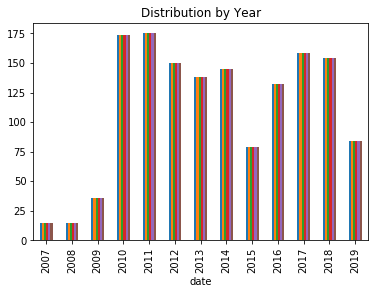

In [39]:
#by year
ax = balanced_df.groupby(balanced_df.date.dt.year).count().plot(kind="bar")
ax.legend_ = None
plt.title("Distribution by Year")
plt.show()

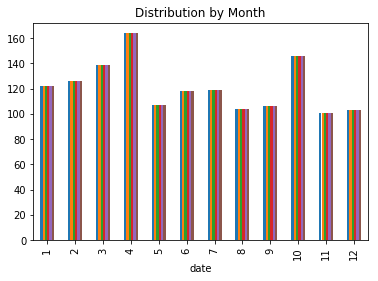

In [40]:
#by month
ax = balanced_df.groupby(balanced_df.date.dt.month).count().plot(kind="bar")
ax.legend_ = None
plt.title("Distribution by Month")
plt.show()

# The quality and balance of the data has improved

In [41]:
cleaned_df = balanced_df[["date","source","freq","statement","veracity"]]

In [42]:
cleaned_df[:100:10]

,date,source,freq,statement,veracity
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False
91,2019-10-01,Gwen Moore,3,"""More than half of death row prisoners are people of color.""",True
295,2019-08-06,Ron Tusler,1,"""Less mass shootings under Trump!""",Pants on Fire!
476,2019-06-12,Ilhan Omar,1,"""Every day on average 500 people die from gun violence.""",False
613,2019-05-02,Terry Gou,1,"""We suspended the (Foxconn) work around October, November last year because the weather there was snowy and icy cold.""",False
668,2019-04-22,William Barr,1,"""The White House fully cooperated with the Special Counsel’s investigation.""",False
755,2019-04-02,Kaye Kory,1,"""Women in Virginia have been incarcerated at an increasingly high rate. It’s around (a) 300 percent increase in the past four or five years.""",False
858,2019-03-07,Phil Berger,1,"""Since 2011, the gap in high school graduation rates between African-American students and all students has been cut in half, from 6.4 percent to 3.1 percent.""",True
1042,2019-01-22,Chuck Woolery,1,"""Nancy Pelosi's bill for alcohol on her flights from Washington to San Fran every week? We pay for it. 1000 dollars. On average 52,000 Bucks, a year for BOOZE. Tax payer money.""",Pants on Fire!
1189,2018-11-16,Lou Dobbs,1,"""We are watching, you know, millions of illegal immigrants cross our borders, and many of them voting in the past election that's what, just a couple weeks ago.""",Pants on Fire!


In [43]:
cleaned_df["length"] = cleaned_df.statement.str.len()

In [44]:
cleaned_df.describe()

,freq,length
count,1455.000000,1455.000000
mean,1.471478,103.346392
std,0.684153,44.491174
min,1.000000,17.000000
25%,1.000000,72.000000
50%,1.000000,94.000000
75%,2.000000,128.000000
max,3.000000,295.000000


In [45]:
cleaned_df[cleaned_df.length > 250][:100]

,date,source,freq,statement,veracity,length
524,2019-05-29,Justin Amash,1,"""In fact, ‘high Crimes and Misdemeanors’ is not defined in the Constitution and does not require corresponding statutory charges. The context implies conduct that violates the public trust—and tha...",True,277
2122,2018-04-13,Jerry Brown,1,"""Here are the facts: there is no massive wave of migrants pouring into California. Overall immigrant apprehensions on the border last year were as low as they’ve been in nearly 50 years (and 85 pe...",True,256
2688,2017-10-27,Delaine Eastin,1,"""Ninety percent of people born in the 1940s ended up doing better financially than their parents. But those born in the 1980s, the much-maligned Millennials, have only a 50-50 chance of doing bett...",True,292
2838,2017-09-15,Kris Kobach,1,"""Facts have come to light that indicate that a pivotal, close election was likely changed through voter fraud on November 8, 2016: New Hampshire’s U.S. Senate Seat, and perhaps also New Hampshire’...",False,257
3504,2017-03-12,Tom Price,1,"""The number of individuals who actually got coverage through the exchange who didn't have coverage before, or who weren't eligible for Medicaid before is relatively small. So we've turned things u...",False,273
4110,2016-10-07,Loretta Sanchez,2,"""If you give guns to gangs, you can get out of jail free, if (California’s Proposition 57) passes. If you do a drive-by shooting, you can get out of jail free, if Proposition 57 passes. If you dis...",False,256
4466,2016-08-04,Richard Durbin,3,"""Illinois suffered 1,652 overdose deaths in 2014 ... of which 40 percent were associated with heroin. Illinois is ranked number one in the nation for a decline in treatment capacity between 2007 a...",True,291
7151,2014-10-02,"Vincent ""Buddy"" Cianci",2,"""[When I was mayor] Providence was one of the five renaissance cities of America, according to USA Today in those days. Money magazine said it was the fifth best city to live in in America. In add...",True,295
8348,2014-01-12,Joseph Cryan,1,"""What do Rutgers University, Kean University, Montclair State University, New Jersey City University, Stockton College, Rowan University and William Paterson all have in common? They all graduate ...",True,254
16080,2008-07-02,Bob Barr,1,"""The legislation ... that Senator McCain supports would provide the authority for the federal government to surveille American citizens in their own country without any suspicion whatsoever that t...",True,271


In [46]:
cleaned_df[cleaned_df.statement.str.match(r"\"Palin")==True]

,date,source,freq,statement,veracity,length
15876,2008-10-01,Defenders of Wildlife Action Fund,1,"""Palin (proposed) a $150 bounty for the severed foreleg of each killed wolf.""",True,77


In [47]:
cleaned_df.head(2)

,date,source,freq,statement,veracity,length
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,93
21,2019-10-22,Brett McGurk,1,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",True,232


In [48]:
cleaned_df.to_csv('politifact_cleaned_data.csv')

In [54]:
trump_df = quote_df[quote_df.source == "Donald Trump"]
trump_df.head(2)

,statement,source,link,veracity,freq
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181
58,"""Fact: Joe Biden pressured Ukraine to fire its prosecutor .... Fact: the prosecutor said he was forced out for leading a corruption probe into Hunter Biden's company. Fact: Democrats want to impea...",Donald Trump,/truth-o-meter/statements/2019/oct/11/donald-trump/trump-ad-misleads-about-biden-ukraine-and-prosecut/,False,181


In [55]:
obama_df = quote_df[quote_df.source == "Barack Obama"]
obama_df.head(2)

,statement,source,link,veracity,freq
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101
4672,"""The steel industry is producing as much steel in the United States as it ever was. It’s just (that) it needs one-tenth of the workers that it used to.""",Barack Obama,/truth-o-meter/statements/2016/jul/05/barack-obama/barack-obama-wrong-about-size-us-steel-production-/,False,101


In [56]:
trump_df.to_csv('politifact_trump_data.csv')
obama_df.to_csv('politifact_obama_data.csv')